In [1]:
import pandas as pd

import numpy as np

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle

In [2]:
train = pd.read_csv('C:\\Users\\Polestar User\\Desktop\\housing\\train.csv')
test = pd.read_csv('C:\\Users\\Polestar User\\Desktop\\housing\\test.csv')

FileNotFoundError: File b'C:\\Users\\Polestar User\\Desktop\\housing\\train.csv' does not exist

In [29]:
data = train.append(test)

In [30]:
############# Numerical Features

numerical = data.select_dtypes(include = ['float64', 'int64'])

############# Categorical features

category = data.select_dtypes(include = ['O'])

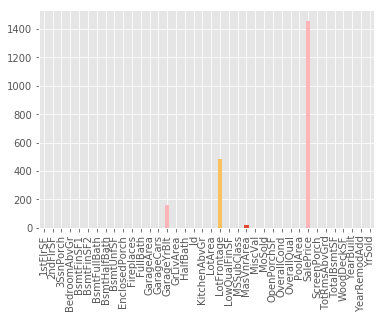

In [32]:
num=numerical.isna().sum()
plt.style.use('ggplot')
num.T.plot(kind='bar')

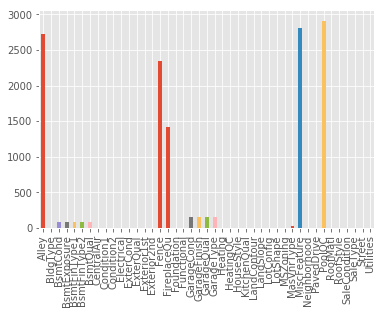

In [33]:
cat=category.isna().sum()
plt.style.use('ggplot')
cat.T.plot(kind='bar')

In [34]:
### FILLING MISSING VALUES

mean_mva=data['MasVnrArea'].mean()
numerical['MasVnrArea']=numerical['MasVnrArea'].fillna(mean_mva)


mean_frontage=numerical['LotFrontage'].mean()
numerical['LotFrontage']=numerical['LotFrontage'].fillna(mean_frontage)

numerical['GarageYrBlt'] = numerical['GarageYrBlt'].fillna(0)

In [35]:
### Deleting columns having high number of missing values from categorical

del category['PoolQC']
del category['Fence']
del category['MiscFeature']
del category['Alley']
del category['FireplaceQu']

In [36]:
#### Filling missing values from categorical


for col in ('GarageType', 'GarageFinish', 'GarageQual','GarageCond'):
    category[col] = category[col].fillna('NoGRG')
    
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    category[col] = category[col].fillna('NoBSMT')
    
category['MasVnrType'] = category['MasVnrType'].fillna(category['MasVnrType'].mode()[0])

category['MSZoning'] = category['MSZoning'].fillna(category['MSZoning'].mode()[0])

category['Electrical'] = category['Electrical'].fillna(category['Electrical'].mode()[0])

category['Exterior1st'] = category['Exterior1st'].fillna('VinylSd')

category['Exterior2nd'] = category['Exterior2nd'].fillna('VinylSd')

category['Functional'] = category['Functional'].fillna('Typ')

category['SaleType'] = category['SaleType'].fillna('WD')

category['Utilities'] = category['Utilities'].fillna('AllPub')

category['KitchenQual'] = category['KitchenQual'].fillna('Gd')


In [37]:
###### Feature Engineering

numerical['Age']=numerical['YrSold'] - numerical['YearBuilt']

numerical['Porch'] =  (numerical['OpenPorchSF']+numerical['EnclosedPorch']+numerical['ScreenPorch']+numerical['3SsnPorch'])/4

numerical['TotalBath']=numerical['FullBath']+numerical['HalfBath']

numerical['TotalSF'] = numerical['TotalBsmtSF'] + numerical['1stFlrSF'] + numerical['2ndFlrSF']



In [39]:
df1 = numerical['SalePrice'].groupby(category['Neighborhood']).mean()

df2 = data['GrLivArea'].groupby(data['Neighborhood']).mean()

df3 = df1/df2

allDict = {'Blmngtn':136.469825,
'Blueste':98.743268,
'BrDale':91.405609,
'BrkSide':103.763006,
'ClearCr':118.877344,
'CollgCr':133.715484,
'Crawfor':117.561846,
'Edwards':95.683487,
'Gilbert':117.499892,
'IDOTRR':87.651248,
'MeadowV':93.089657,
'Mitchel':120.746121,
'NAmes':111.307215,
'NPkVill':113.882238,
'NWAmes':109.417853,
'NoRidge':133.644829,
'NridgHt':165.072651,
'OldTown':86.654779,
'SWISU':79.162888,
'Sawyer':112.574422,
'SawyerW':116.961639,
'Somerst':141.157845,
'StoneBr':165.239905,
'Timber':138.477089,
'Veenker':155.083845}


numerical['PricePSF'] = category['Neighborhood'].copy()


numerical["PricePSF"].replace(allDict, inplace=True)

In [40]:
Allfeatures = pd.concat([numerical,category],axis=1)


####

Allfeatures.drop(['Utilities', 'RoofMatl', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
               'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'WoodDeckSF',
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
              axis=1, inplace=True)


Allfeatures['TotalSF'] = Allfeatures['TotalSF'].fillna(800)

In [43]:
del Allfeatures['SalePrice']
del Allfeatures['Condition2']
del Allfeatures['Electrical']
del Allfeatures['Exterior1st']
del Allfeatures['Exterior2nd']
del Allfeatures['HouseStyle']
del Allfeatures['GarageQual']

In [47]:
Allfeatures['GarageCars'] = Allfeatures['GarageCars'].fillna(2)
Allfeatures['TotalBsmtSF'] = Allfeatures['TotalBsmtSF'].fillna(800)

In [48]:
numeric_features = [f for f in Allfeatures.columns if Allfeatures[f].dtype != object]

scaler = MinMaxScaler()
o=scaler.fit(Allfeatures[numeric_features])
scaled = scaler.transform(Allfeatures[numeric_features])

for i, col in enumerate(numeric_features):
       Allfeatures[col] = scaled[:,i]

In [2]:
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))

# Shows scores for train and validation sets    
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    # Printing train scores
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    get_score(prediction_test, y_tst)

In [49]:
train1 = Allfeatures[0:1460]
test1 = Allfeatures[1460:]

In [16]:
X = pd.read_csv("C:\\Users\\Polestar User\\Documents\\regression\\HouseProblem\\rehousing\\attachments00\\new_train2.csv")

test = pd.read_csv('C:\\Users\\Polestar User\\Documents\\regression\\HouseProblem\\rehousing\\attachments00\\new_test2.csv') ## remove

y = X['SalePrice']

del X['SalePrice']

In [50]:
X = train1.copy()

y = train['SalePrice']


X = pd.get_dummies(X)

test1 = pd.get_dummies(test1)

y = np.log(y)

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(X,y)

pred = regr.predict(test1)

predtest=np.exp(pred)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=200)


In [20]:
regr = linear_model.LinearRegression()
regr.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
train_test(regr, x_train, x_test, y_train, y_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
R2: 0.9530034908188395
RMSE: 0.029283096970713747
Test
R2: 0.9192094934123508
RMSE: 0.03499912437218976


In [23]:
scores = cross_val_score(regr, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -92.51 (+/- 348.45)


In [54]:
sub1 = pd.DataFrame()
sub1['Id'] = test['Id']
sub1['SalePrice'] = predtest
sub1.to_csv('C:\\Users\\Polestar User\\Desktop\\finalsubmit\\submission2.csv',index=False)


In [55]:
#Score = 0.13771 Kaggle Rank = 2225

In [56]:
#######Second Model#########

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
lasso = LassoCV(alphas=[0.001,.0001,.0015],cv=10,random_state = 1).fit(X,y)

lasso.score(X,y)

lasso.alpha_

lasso.coef_

predtest = lasso.predict(test1)
predtest=np.exp(predtest)

sub1 = pd.DataFrame()
sub1['Id'] = test['Id']
sub1['SalePrice'] = predtest
sub1.to_csv('C:\\Users\\Polestar User\\Desktop\\finalsubmit\\submission3.csv',index=False)



In [57]:
#Score = 0.13443 , Kaggle Rank = 2007

In [58]:
####### Third Model ################

ENSTest = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], cv=10,max_iter=5000).fit(X,y)

ENSTest.alpha_

predtest = ENSTest.predict(test1)
predtest=np.exp(predtest)

sub1 = pd.DataFrame()
sub1['Id'] = test['Id']
sub1['SalePrice'] = predtest
sub1.to_csv('C:\\Users\\Polestar User\\Desktop\\finalsubmit\\submission5.csv',index=False)

In [59]:
#Score = 0.13204 , kaggle Rank = 1840

In [ ]:
###### Forth Model ################

GBest = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber').fit(X, y)

predtest = GBest.predict(test1)
predtest=np.exp(predtest)

sub1 = pd.DataFrame()
sub1['Id'] = test['Id']
sub1['SalePrice'] = predtest
sub1.to_csv('C:\\Users\\Polestar User\\Desktop\\finalsubmit\\submission6.csv',index=False)


In [ ]:
#score = 0.12254 , Kaggle Rank = 1217

In [ ]:
####### model 5 by stacking ###########

GB_model = GBest.fit(X, y)
ENST_model = ENSTest.fit(X, y)


Final_labels = (np.exp(GB_model.predict(test1)) + np.exp(ENST_model.predict(test1))) / 2

sub1 = pd.DataFrame()
sub1['Id'] = test['Id']
sub1['SalePrice'] = Final_labels
sub1.to_csv('C:\\Users\\Polestar User\\Desktop\\finalsubmit\\submission7.csv',index=False)


In [ ]:
#Score = 0.12211, Kaggle rank = 1176

In [1]:
######################################################################################################################

In [ ]:
                                             # Final Model        

In [ ]:
######################################################################################################################

In [3]:
train = pd.read_csv("C:\\Users\\Polestar User\\Desktop\\data2train.csv")
test = pd.read_csv("C:\\Users\\Polestar User\\Desktop\\data2test.csv")


In [ ]:
train.drop(train[train["GrLivArea"] > 4000].index, inplace=True)

In [ ]:
data = train.append(test)

In [ ]:
qual_dict = {None: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

data["ExterQual"] = df["ExterQual"].map(qual_dict).astype(int)
data["ExterCond"] = df["ExterCond"].map(qual_dict).astype(int)
data["BsmtQual"] = df["BsmtQual"].map(qual_dict).astype(int)
data["BsmtCond"] = df["BsmtCond"].map(qual_dict).astype(int)
data["HeatingQC"] = df["HeatingQC"].map(qual_dict).astype(int)
data["KitchenQual"] = df["KitchenQual"].map(qual_dict).astype(int)
data["FireplaceQu"] = df["FireplaceQu"].map(qual_dict).astype(int)
data["GarageQual"] = df["GarageQual"].map(qual_dict).astype(int)
data["GarageCond"] = df["GarageCond"].map(qual_dict).astype(int)

data["BsmtExposure"] = df["BsmtExposure"].map({None: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)

data["Functional"] = df["Functional"].map({None: 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}).astype(int)

data["GarageFinish"] = df["GarageFinish"].map({None: 0, "Unf": 1, "RFn": 2, "Fin": 3}).astype(int)

data["Fence"] = df["Fence"].map({None: 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def factorize(df, factor_df, column, fill_na=None):
    factor_df[column] = df[column]
    if fill_na is not None:
        factor_df[column].fillna(fill_na, inplace=True)
    le.fit(factor_df[column].unique())
    factor_df[column] = le.transform(factor_df[column])
    return factor_df


data = factorize(df, data, "MSSubClass")
data = factorize(df, data, "MSZoning", "RL")
data = factorize(df, data, "LotConfig")
data = factorize(df, data, "Neighborhood")
data = factorize(df, data, "Condition1")
data = factorize(df, data, "BldgType")
data = factorize(df, data, "HouseStyle")
data = factorize(df, data, "RoofStyle")
data = factorize(df, data, "Exterior1st", "Other")
data = factorize(df, data, "Exterior2nd", "Other")
data = factorize(df, data, "MasVnrType", "None")
data = factorize(df, data, "Foundation")
data = factorize(df, data, "SaleType", "Oth")
data = factorize(df, data, "SaleCondition")

In [ ]:
data["IsRegularLotShape"] = (df["LotShape"] == "Reg") * 1
data["IsLandLevel"] = (df["LandContour"] == "Lvl") * 1
data["IsLandSlopeGentle"] = (df["LandSlope"] == "Gtl") * 1
data["IsElectricalSBrkr"] = (df["Electrical"] == "SBrkr") * 1
data["IsGarageDetached"] = (df["GarageType"] == "Detchd") * 1
data["IsPavedDrive"] = (df["PavedDrive"] == "Y") * 1
data["HasShed"] = (df["MiscFeature"] == "Shed") * 1.  
data["Remodeled"] = (all_df["YearRemodAdd"] != all_df["YearBuilt"]) * 1
data["RecentRemodel"] = (all_df["YearRemodAdd"] == all_df["YrSold"]) * 1
data["VeryNewHouse"] = (all_df["YearBuilt"] == all_df["YrSold"]) * 1

In [ ]:
data["HighSeason"] = df["MoSold"].replace( {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})

data["Age"] = 2010 - all_df["YearBuilt"]

data["BadHeating"] = df.HeatingQC.replace({'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})

data["TotalArea1st2nd"] = data["1stFlrSF"] + data["2ndFlrSF"]


In [ ]:
data["SimplOverallQual"] = data.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})

data["SimplOverallCond"] = data.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})

data["SimplPoolQC"] = data.PoolQC.replace({1 : 1, 2 : 1, 3 : 2, 4 : 2})

data["SimplGarageCond"] = data.GarageCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})

data["SimplGarageQual"] = data.GarageQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})

data["SimplFireplaceQu"] = data.FireplaceQu.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})

data["SimplFireplaceQu"] = data.FireplaceQu.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})

data["SimplFunctional"] = data.Functional.replace({1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 6 : 3, 7 : 3, 8 : 4})

data["SimplKitchenQual"] = data.KitchenQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})

data["SimplHeatingQC"] = data.HeatingQC.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})

data["SimplBsmtFinType1"] = data.BsmtFinType1.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})

data["SimplBsmtFinType2"] = data.BsmtFinType2.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})

data["SimplBsmtCond"] = data.BsmtCond.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})

data["SimplBsmtQual"] = data.BsmtQual.replace({1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})

In [ ]:
data["SalePrice"].groupby(data["Neighborhood"]).median().sort_values()
neighborhood_map = {
        "MeadowV" : 0,  #  88000
        "IDOTRR" : 1,   # 103000
        "BrDale" : 1,   # 106000
        "OldTown" : 1,  # 119000
        "Edwards" : 1,  # 119500
        "BrkSide" : 1,  # 124300
        "Sawyer" : 1,   # 135000
        "Blueste" : 1,  # 137500
        "SWISU" : 2,    # 139500
        "NAmes" : 2,    # 140000
        "NPkVill" : 2,  # 146000
        "Mitchel" : 2,  # 153500
        "SawyerW" : 2,  # 179900
        "Gilbert" : 2,  # 181000
        "NWAmes" : 2,   # 182900
        "Blmngtn" : 2,  # 191000
        "CollgCr" : 2,  # 197200
        "ClearCr" : 3,  # 200250
        "Crawfor" : 3,  # 200624
        "Veenker" : 3,  # 218000
        "Somerst" : 3,  # 225500
        "Timber" : 3,   # 228475
        "StoneBr" : 4,  # 278000
        "NoRidge" : 4,  # 290000
        "NridgHt" : 4,  # 315000
    }

data["NeighborhoodBin"] = data["Neighborhood"].map(neighborhood_map)

In [ ]:
train1 = data[0:1460]
test1 = data[1460:]

In [25]:
X = pd.read_csv("C:\\Users\\Polestar User\\Documents\\regression\\HousePriceFinal\\data2train.csv")

y = pd.read_csv('C:\\Users\\Polestar User\\Documents\\regression\\HousePriceFinal\\data2saleprice.csv')


In [ ]:
################ Elastic #########################

y = train["SalePrice"].copy()
y = np.log(y)

X = train1

ENSTest = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], cv=10,max_iter=5000).fit(X,y)

predtest = ENSTest.predict(test1)
predtest=np.exp(predtest)

sub1 = pd.DataFrame()
sub1['Id'] = test['Id']
sub1['SalePrice'] = predtest
sub1.to_csv('C:\\Users\\Polestar User\\Desktop\\finalsubmit\\data2elastic.csv',index=False)


In [8]:
ENSTest = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], cv=10,max_iter=5000).fit(X,y)


In [9]:
train_test(ENSTest, x_train, x_test, y_train, y_test)

ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], copy_X=True,
       cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.5, 0.9, 0.99], max_iter=5000, n_alphas=100,
       n_jobs=1, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)
R2: 0.9392174270209931
RMSE: 0.09474306135584167
Test
R2: 0.9092503208670178
RMSE: 0.1080338080750225


In [26]:
scores = cross_val_score(ENSTest, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.92 (+/- 0.01)


In [ ]:
#Score = 0.11783, Kaggle rank = 787

In [ ]:
############## GBM ###############################

GBest = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber').fit(X, y)

predtest = GBest.predict(test1)
predtest=np.exp(predtest)

sub1 = pd.DataFrame()
sub1['Id'] = test['Id']
sub1['SalePrice'] = predtest
sub1.to_csv('C:\\Users\\Polestar User\\Desktop\\finalsubmit\\data2GBM.csv',index=False)


In [10]:
GBest = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber').fit(X, y)


In [13]:
train_test(GBest, x_train, x_test, y_train, y_test)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
R2: 0.9793539993956283
RMSE: 0.05555256013505683
Test
R2: 0.9638774071730726
RMSE: 0.06829965450172118


In [27]:
scores = cross_val_score(GBest, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.92 (+/- 0.01)


In [ ]:
#Score = 0.12283, Kaggle rank = 787

In [ ]:
############# Stacking #########################

GB_model = GBest.fit(X, y)
ENST_model = ENSTest.fit(X, y)


Final_labels = (np.exp(GB_model.predict(test1)) + np.exp(ENST_model.predict(test1))) / 2

sub1 = pd.DataFrame()
sub1['Id'] = test['Id']
sub1['SalePrice'] = Final_labels
sub1.to_csv('C:\\Users\\Polestar User\\Desktop\\finalsubmit\\data2stack.csv',index=False)



In [ ]:
#Score = 0.11488 , Kaggle rank = 283